C:\Users\DELL-2025\AppData\Local\Temp\ipykernel_12244\3484341145.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trades_df = pd.read_csv("csv_files/historical_data.csv", parse_dates=["Timestamp"])
C:\Users\DELL-2025\AppData\Local\Temp\ipykernel_12244\3484341145.py:47: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  trades_df['Timestamp'] = pd.to_datetime(trades_df['Timestamp'], unit='ms')



================= SENTIMENT COMPARISON ===============
         metric     greed_mean      fear_mean    t_stat   p_value
0       net_pnl    3510.513063    4070.425857 -0.107930  0.914059
1  avg_leverage       0.000000       0.000000       NaN       NaN
2  total_volume  438273.659502  252365.808980  0.424925  0.670942



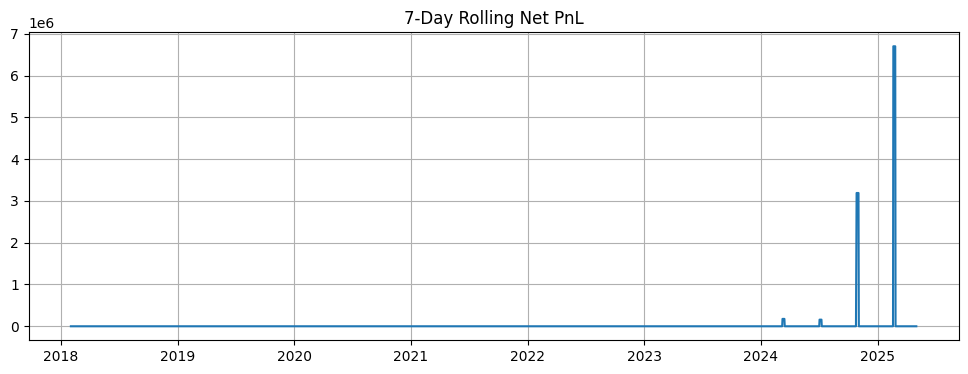

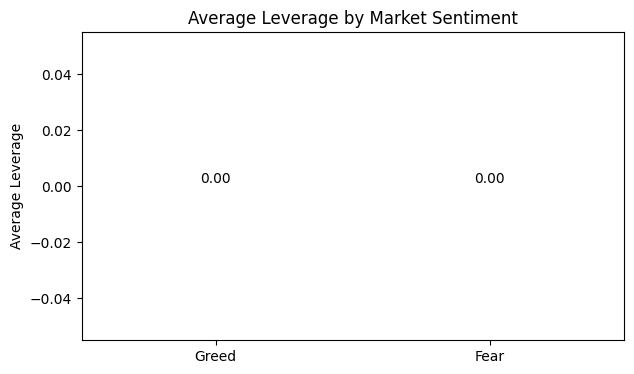

<Figure size 600x400 with 0 Axes>

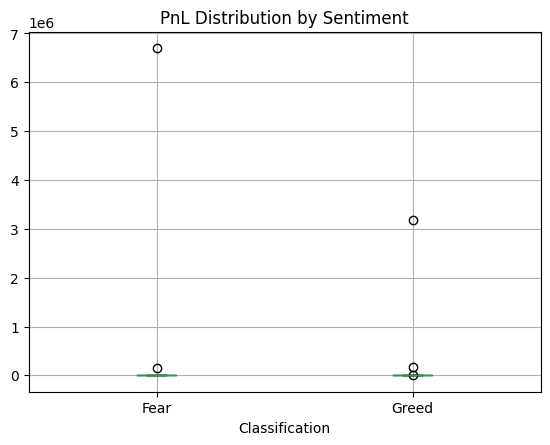

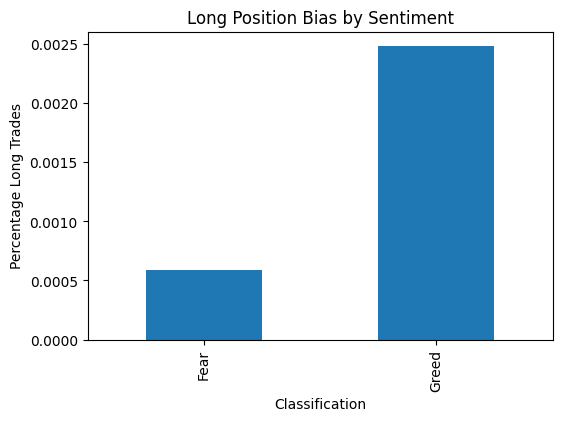

In [7]:
# -------------------------------------------------
# 1) IMPORT LIBRARIES
# -------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# -------------------------------------------------
# 2) LOAD SENTIMENT DATA
# -------------------------------------------------
sentiment_df = pd.read_csv(r'csv_files/fear_greed_index.csv', parse_dates=["date"])

# Clean column names
sentiment_df.columns = [c.strip() for c in sentiment_df.columns]

# Normalize date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.floor('d')

# Keep needed columns
sentiment_df = sentiment_df[['date', 'classification']].drop_duplicates(subset=['date'])

# Standardize classification values (IMPORTANT FIX)
sentiment_df['classification'] = sentiment_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Neutral': 'Fear',         # optional: treat Neutral as Fear
    'Greed': 'Greed',
    'Extreme Greed': 'Greed'
}).str.strip().str.title()     # ensures "Greed" / "Fear"

sentiment_df = sentiment_df.rename(columns={
    'date': 'Date',
    'classification': 'Classification'
})

# -------------------------------------------------
# 3) LOAD TRADER DATA
# -------------------------------------------------
trades_df = pd.read_csv("csv_files/historical_data.csv", parse_dates=["Timestamp"])

# Clean columns (fix spaces!!)
trades_df.columns = [c.strip() for c in trades_df.columns]

# Convert timestamp (if ms)
try:
    trades_df['Timestamp'] = pd.to_datetime(trades_df['Timestamp'], unit='ms')
except:
    trades_df['Timestamp'] = pd.to_datetime(trades_df['Timestamp'])

# Add daily column
trades_df['date'] = trades_df['Timestamp'].dt.floor('d')

# -------------------------------------------------
# 3A) FIX LEVERAGE COLUMN (Auto-detect)
# -------------------------------------------------
possible_lev = [col for col in trades_df.columns if 'lev' in col.lower()]
if len(possible_lev) > 0:
    lev_col = possible_lev[0]  # first matching column
else:
    lev_col = 'leverage'
    trades_df[lev_col] = 0

# Ensure numeric leverage
trades_df[lev_col] = pd.to_numeric(trades_df[lev_col], errors='coerce').fillna(0)

# -------------------------------------------------
# FIX SIZE & PNL COLUMNS (Auto-detect)
# -------------------------------------------------
# Size
possible_size = [col for col in trades_df.columns if 'size' in col.lower()]
size_col = possible_size[0] if possible_size else 'Size Tokens'
trades_df[size_col] = pd.to_numeric(trades_df[size_col], errors='coerce').fillna(0)

# PnL
possible_pnl = [col for col in trades_df.columns if 'pnl' in col.lower()]
pnl_col = possible_pnl[0] if possible_pnl else 'Closed PnL'
trades_df[pnl_col] = pd.to_numeric(trades_df[pnl_col], errors='coerce').fillna(0)

# -------------------------------------------------
# 4) DAILY AGGREGATION
# -------------------------------------------------
daily = trades_df.groupby('date').agg(
    trade_count=('Account', 'count'),
    total_volume=(size_col, 'sum'),
    avg_leverage=(lev_col, 'mean'),
    net_pnl=(pnl_col, 'sum'),
    avg_pnl_per_trade=(pnl_col, 'mean'),
    long_bias=('Side', lambda x: (x.str.strip().str.lower() == 'buy').mean())
).reset_index().rename(columns={'date': 'Date'})

# -------------------------------------------------
# 5) MERGE SENTIMENT & TRADING DATA
# -------------------------------------------------
merged = pd.merge(sentiment_df, daily, on='Date', how='left').fillna(0)
merged = merged.sort_values('Date')

# -------------------------------------------------
# 6) ADD ROLLING FEATURES
# -------------------------------------------------
merged['net_pnl_7d'] = merged['net_pnl'].rolling(7, min_periods=1).sum()
merged['volume_7d'] = merged['total_volume'].rolling(7, min_periods=1).sum()
merged['net_pnl_lag1'] = merged['net_pnl'].shift(1).fillna(0)

# Split by sentiment
greed = merged[merged['Classification'] == 'Greed']
fear = merged[merged['Classification'] == 'Fear']

# -------------------------------------------------
# 7) STATS COMPARISON
# -------------------------------------------------
t_netpnl = stats.ttest_ind(greed['net_pnl'], fear['net_pnl'], equal_var=False, nan_policy='omit')
t_leverage = stats.ttest_ind(greed['avg_leverage'], fear['avg_leverage'], equal_var=False, nan_policy='omit')
t_volume = stats.ttest_ind(greed['total_volume'], fear['total_volume'], equal_var=False, nan_policy='omit')

summary_stats = pd.DataFrame({
    "metric": ["net_pnl", "avg_leverage", "total_volume"],
    "greed_mean": [
        greed['net_pnl'].mean(),
        greed['avg_leverage'].mean(),
        greed['total_volume'].mean()
    ],
    "fear_mean": [
        fear['net_pnl'].mean(),
        fear['avg_leverage'].mean(),
        fear['total_volume'].mean()
    ],
    "t_stat": [t_netpnl.statistic, t_leverage.statistic, t_volume.statistic],
    "p_value": [t_netpnl.pvalue, t_leverage.pvalue, t_volume.pvalue]
})

print("\n================= SENTIMENT COMPARISON ===============")
print(summary_stats)
print("======================================================\n")

# -------------------------------------------------
# 8) VISUALIZATIONS
# -------------------------------------------------

# ---- PLOT 1: Rolling PnL ----
plt.figure(figsize=(12, 4))
plt.plot(merged['Date'], merged['net_pnl_7d'])
plt.title("7-Day Rolling Net PnL")
plt.grid(True)
plt.show()

# ---- PLOT 2: Avg Leverage by Sentiment ----
plt.figure(figsize=(7, 4))
cat = merged.groupby('Classification')['avg_leverage'].mean().reindex(['Greed', 'Fear'])
plt.bar(cat.index, cat.values)

# Add values above bars
for i, v in enumerate(cat.values):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.title("Average Leverage by Market Sentiment")
plt.ylabel("Average Leverage")
plt.show()

# ---- PLOT 3: PnL Distribution ----
plt.figure(figsize=(6, 4))
merged.boxplot(column='net_pnl', by='Classification')
plt.title("PnL Distribution by Sentiment")
plt.suptitle("")
plt.show()

# ---- PLOT 4: Long Bias ----
plt.figure(figsize=(6, 4))
merged.groupby('Classification')['long_bias'].mean().plot(kind='bar')
plt.title("Long Position Bias by Sentiment")
plt.ylabel("Percentage Long Trades")
plt.show()
